## Visualizing Results of the Deletion Capacity Experiment

These are the results of the deletion capacity experiment. 

At a high level, we're seeing very conservative regret bounds for the Memory Pair. This means that we're requiring large sample complexity in return for a very low deletion capacity.

It's also worth noting that our sample complexity (bar for a good learner) increases as the data wiggles more. When the Lipschitz constant and upper-bound on the Hessian are high, the sample complexity jumps and the amount of noise injected to the model becomes destabilizingly high.

Goals:
- Analyze the simulation results from the experiment runs and visualize the cumulative regret
- Focus on $\widehat{G}$ such that we can see its impact on the downstream stability of the learner
- Investigate alternative methods of privacy accounting. Can we get tigheter regret bounds such that we don't inject so much noise into the parameter estimates.

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/workspaces/unlearning-research-meta/experiments/deletion_capacity/results/grid_2025_01_01/sweep/all_runs.csv")

The data is at a very granular level, which will make analysis fun.

The code performs a grid search over the experiment parameters. For each seed, a memory pair is trained to its theoretical sample complexity (after an initial calibration period). Once the warmup is complete, the model is tasked with a series of deletions. The goal is to evaluate the impact of unlearning on the model's regret convergence. 

The conservative bounds of the traditional $(\varepsilon,\delta)$-certified unlearning method makes it a difficult task. The conservative accountant assumes that every deletion is of the worst-possible sensitivity, and so an unsustainable amount of noise is added to the Newton Step.

In [3]:
summary_statistics = data.describe()
summary_statistics.columns

/workspaces/unlearning-research-meta/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/workspaces/unlearning-research-meta/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Index(['acc', 'capacity_remaining', 'delta_step_theory', 'delta_total',
       'eps_spent', 'eps_step_theory', 'event', 'regret', 'seed',
       'gamma_learn_grid', 'gamma_priv_grid', 'quantile_grid',
       'delete_ratio_grid', 'avg_regret_empirical', 'N_star_emp', 'm_emp',
       'final_acc', 'total_events', 'gamma_learn', 'gamma_priv', 'quantile',
       'delete_ratio', 'eps_total', 'eps_converted', 'eps_remaining'],
      dtype='object')

In [4]:
seed_level_data = data.loc[data["acc"].isnull() & data["avg_regret_empirical"]]
event_level_data = data.loc[data["avg_regret_empirical"].isnull()]

- How many seeds do we have per Grid ID? At most 4.
- What does regret look like for a single experiment run?
- How does the theoretical $N^{\star}$ compare with the empirical limit?
- How does the average regret compare with the theoretical gamma bound?
- Describe the three regimes of sample complexity
- Describe the impact of deletion on event-level regret
- How does the strength of noise (sigma) scale with G?

## What does regret look like for a single experiment?

I grabbed 10 sample Grid IDs and pulled the corresponding events. The goal is to identify what the regret accumulation looks like for a random sample of events.

At first the data increases pretty steeply, but then tapers off around 200 training observations. Empirically, I would consider the empirical sample complexity to be somewhere between 200 and 300. But many of the experiments require a much higher sample complexity due to the conservative bounds of the algorithm.

In [5]:
# get unique grid IDs
unique_grid_ids = data.loc[data["accountant_grid"] == "legacy","grid_id"].unique()

random_ids = random.choices(
    unique_grid_ids,
    k = 10
)

# fetch the random experiments
random_experiment_events = event_level_data[event_level_data["grid_id"].isin(random_ids)]

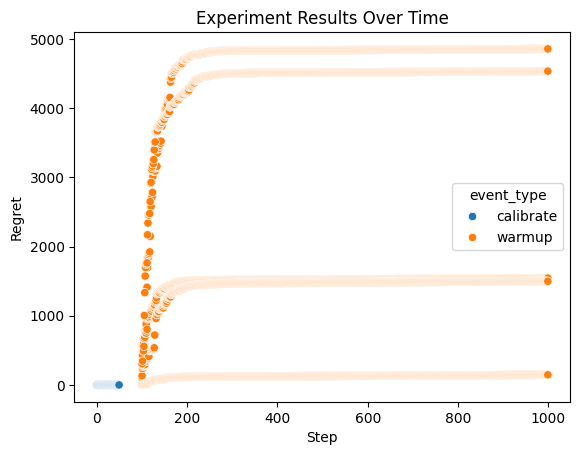

In [6]:
# plot a scatter plot of step vs regret colored by event type
sns.scatterplot(data=random_experiment_events, x="event", y="regret", hue="event_type")
plt.title("Experiment Results Over Time")
plt.xlabel("Step")
plt.ylabel("Regret")
plt.show()

## How does our empirical sample complexity $N^{*}$ align with the theoretical?

If it looks like regret plateaus at 300 training events, is this the same as our empirical sample complexity? How does this compare with the theoretical sample complexity, which is the point at which we obtain a certain amout of average regret?